In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.collab import * 
from fastai.tabular.all import * 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ratings = pd.read_csv("/kaggle/input/goodbooks-10k/ratings.csv")
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [3]:
books = pd.read_csv("/kaggle/input/goodbooks-10k/books.csv")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


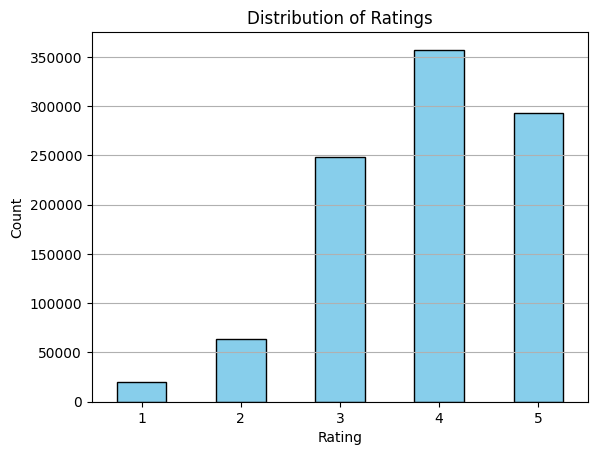

In [4]:
rating_counts = ratings['rating'].value_counts().sort_index()

rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Text(0.5, 1.0, 'Distribution of Average Book Ratings')

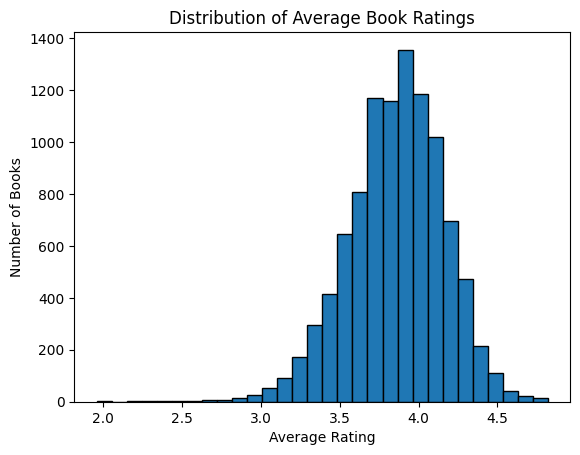

In [5]:
avg_ratings = ratings.groupby('book_id')['rating'].mean()
avg_ratings.plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.title('Distribution of Average Book Ratings')

<Axes: xlabel='original_title'>

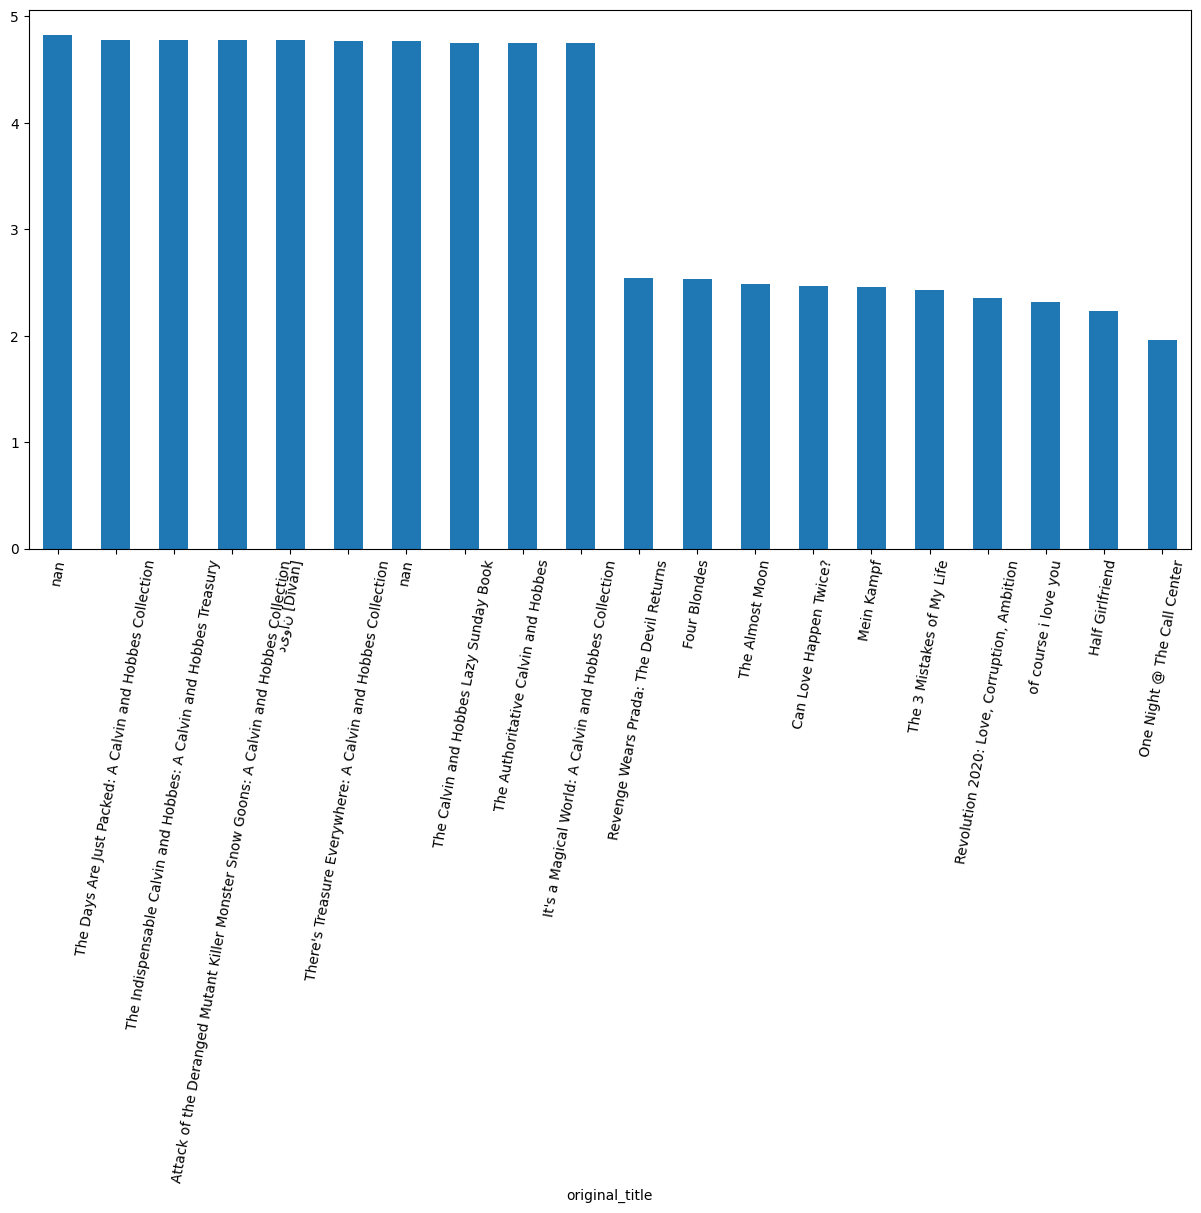

In [6]:
avg_ratings = ratings.groupby('book_id')['rating'].mean().sort_values(ascending=False)
top_n = 10
# First, merge average ratings with books on book_id
merged = avg_ratings.reset_index().merge(books[['id', 'original_title']], left_on='book_id', right_on='id')

# Sort by ratings again
sorted_books = merged.sort_values(by='rating', ascending=False)

# Plot
pd.concat([sorted_books.head(top_n), sorted_books.tail(top_n)]).set_index('original_title')['rating'].plot(kind='bar', figsize=(15, 7), rot=80)



In [7]:
# Merge on book_id, keeping only the desired columns
merged_df = ratings.merge(books[['id', 'original_title']], left_on='book_id', right_on='id', how='left')[['book_id', 'user_id', 'rating', 'original_title']]

# Rename the original_title column to title
merged_df = merged_df.rename(columns={'original_title': 'title'})

merged_df.head()

,book_id,user_id,rating,title
0,1,314,5,The Hunger Games
1,1,439,3,The Hunger Games
2,1,588,5,The Hunger Games
3,1,1169,4,The Hunger Games
4,1,1185,4,The Hunger Games


In [8]:
dls = CollabDataLoaders.from_df(merged_df, item_name = 'title', user_name='user_id',bs=64)
dls.show_batch()

,user_id,title,rating
0,51770,Pathfinder,3
1,15645,"Promise Me (Myron Bolitar, #8)",4
2,3540,Surface Detail,4
3,6960,Getting Stoned with Savages: A Trip Through the Islands of Fiji and Vanuatu,4
4,8370,Animal Farm: A Fairy Story,3
5,49752,Shūtur eli sharrī,5
6,16092,Two-Way Street,1
7,46247,The Melancholy Death of Oyster Boy and Other Stories,3
8,18494,Dandelion Wine,5
9,42806,Jimmy Corrigan: The Smartest Kid on Earth,5


In [9]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['title'])
n_factors = 5

n_users, n_books

(53070, 9275)

In [10]:
user_factors = torch.randn(n_users,n_factors)
book_factors = torch.randn(n_books,n_factors)

## X, y from the DLS represents x as a batch of 64x2 where the first column is user id's, and the second column is book id's

the code self.user_factors(x[:,0]) takes in the user ID's looks them up in the embedding to get the factors and then does the same for the book ID's and takes the dot product

In [11]:
class DotProductBias(Module):
    def __init__(self, n_users, n_books, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users,n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.book_factors = Embedding(n_books,n_factors)
        self.book_bias = Embedding(n_books,1)
        self.y_range = y_range
    
    def forward(self,x):
        users = self.user_factors(x[:,0])
        books = self.book_factors(x[:,1])
        residual = (users*books).sum(dim=1, keepdim=True)
        residual += self.user_bias(x[:,0]) + self.book_bias(x[:,1])
        return sigmoid_range(residual, *self.y_range)

In [12]:
model = DotProductBias(n_users,n_books,50)
learn = Learner(dls,model, loss_func= MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.846349,0.848089,01:14
1,0.759162,0.798559,01:13
2,0.551119,0.776408,01:14
3,0.334450,0.759450,01:13
4,0.213561,0.761878,01:12


In [13]:
learn.model.book_bias

Embedding(9275, 1)

In [16]:
book_bias = learn.model.book_bias.weight.squeeze()
idxs = book_bias.argsort()[:50]
[dls.classes['title'][i] for i in idxs]

['One Night @ The Call Center',
 'Half Girlfriend',
 'Fifty Shades of Grey',
 'Revolution 2020: Love, Corruption, Ambition',
 'of course i love you',
 'The 3 Mistakes of My Life',
 'Four Blondes',
 'Revenge Wears Prada: The Devil Returns',
 'ليتها تقرأ',
 'Fifty Shades Freed',
 'Pygmy',
 'The Jane Austen Book Club',
 'The Prophet of Yonwood',
 'Trading Up',
 "Left Behind:  A Novel of the Earth's Last Days",
 'The Almost Moon',
 'Mein Kampf',
 'Can Love Happen Twice?',
 'Witch & Wizard',
 'Beautiful You',
 'Sex and the City',
 'Tell-All',
 'Violin',
 'Leven Thumps and the Gateway to Foo (Leven Thumps, #1)',
 'I Too Had A Love Story',
 'Twilight: The Graphic Novel',
 'Cocktails for Three',
 'Fifty Shades Darker',
 'Ink Exchange (Wicked Lovely, #2)',
 'The Return: Nightfall',
 'The Vampire Diaries: The Return: Midnight',
 'Ethan Frome',
 'Vampire Kisses',
 'Dark Flame',
 'The Funhouse',
 'Adultério',
 'The Particular Sadness of Lemon Cake',
 'Night Star',
 'Lost',
 "The Emperor's Children

In [17]:
idxs = book_bias.argsort(descending=True)[:50]
[dls.classes['title'][i] for i in idxs]

['Humans of New York: Stories',
 'دیوان\u200e\u200e [Dīvān]',
 'Mark of the Lion Trilogy',
 'Jesus the Christ: A Study of the Messiah and His Mission according to Holy Scriptures both Ancient and Modern',
 'Harry Potter Collection (Harry Potter, #1-6)',
 ' الرحيق المختوم: بحث في السيرة النبوية على صاحبها أفضل الصلاة والسلام ',
 'Livro do Desassossego',
 'The Shawshank Redemption',
 'The Absolute Sandman, Volume One',
 'This is Water',
 'The Days Are Just Packed: A Calvin and Hobbes Collection',
 'The Complete Calvin and Hobbes',
 'The Indispensable Calvin and Hobbes: A Calvin and Hobbes Treasury',
 'Attack of the Deranged Mutant Killer Monster Snow Goons: A Calvin and Hobbes Collection',
 'Preach My Gospel (A Guide to Missionary Service)',
 'A Court of Mist and Fury',
 'The Hate U Give',
 'The Calvin and Hobbes Lazy Sunday Book',
 'The Authoritative Calvin and Hobbes',
 'The Book with No Pictures',
 'Words of Radiance',
 'This is Not My Hat',
 'I Want My Hat Back',
 "India After Gandhi

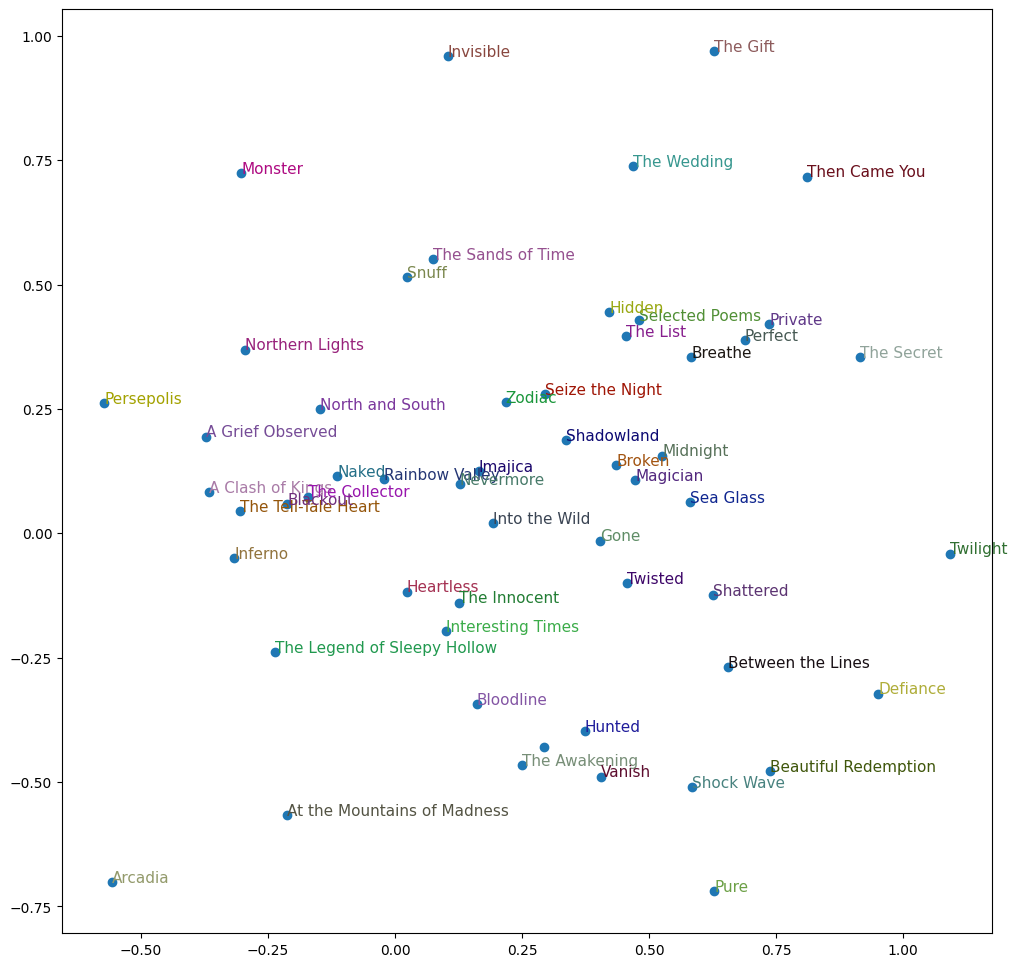

In [18]:
g = merged_df.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_books])
book_w = learn.model.book_factors.weight[top_idxs].cpu().detach()
book_pca = book_w.pca(3)
fac0,fac1,fac2 = book_pca.t()
idxs = list(range(55))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()
     

In [19]:
book_factors = learn.model.book_factors.weight
idx = dls.classes['title'].o2i['Harry Potter Collection (Harry Potter, #1-6)']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:5]
dls.classes['title'][idx]
     

(#4) ['The Warlord Wants Forever','Saint Odd','Acheron (Dark-Hunter, #15) - Part 1','Lady Midnight']

In [20]:
book_factors = learn.model.book_factors.weight
idx = dls.classes['title'].o2i['Harry Potter Collection (Harry Potter, #1-6)']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=False)[1:5]
dls.classes['title'][idx]

(#4) ['نسيان كوم','عابر سرير','The Horse Whisperer','Skellig']

In [21]:
book_factors = learn.model.book_factors.weight
idx = dls.classes['title'].o2i['Twilight']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1:5]
dls.classes['title'][idx]
     

(#4) ['Chicken Soup for the Soul','Mastery','The Black Lyon','Starlight (Warriors: The New Prophecy, #4)']

In [22]:
book_factors = learn.model.book_factors.weight
idx = dls.classes['title'].o2i['Twilight']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=False)[1:5]
dls.classes['title'][idx]
     

(#4) ['Animal Farm: A Fairy Story','The Light Between Oceans','Brave New World','Lord of the Flies ']

## Movies:

In [23]:
path = untar_data(URLs.ML_100k)

In [24]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [25]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [26]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [29]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

In [30]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,889,Clockers (1995),3
1,416,"Ghost and the Darkness, The (1996)",5
2,751,Primal Fear (1996),1
3,378,"Nightmare Before Christmas, The (1993)",3
4,586,Aliens (1986),3
5,503,"Remains of the Day, The (1993)",5
6,793,Switchblade Sisters (1975),2
7,621,"Crucible, The (1996)",3
8,699,Kama Sutra: A Tale of Love (1996),3
9,588,Breakfast at Tiffany's (1961),5


In [33]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.935864,0.941247,00:07
1,0.841627,0.857570,00:07
2,0.733369,0.820981,00:07
3,0.583755,0.810565,00:07
4,0.487630,0.812162,00:07


In [35]:
# even when factors don't match, people like it

movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 'As Good As It Gets (1997)',
 "Schindler's List (1993)",
 'Silence of the Lambs, The (1991)']

In [36]:
# factors match, people dont like it

movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=False)[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 'Jury Duty (1995)',
 'Beautician and the Beast, The (1997)',
 'Best of the Best 3: No Turning Back (1995)']

In [44]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

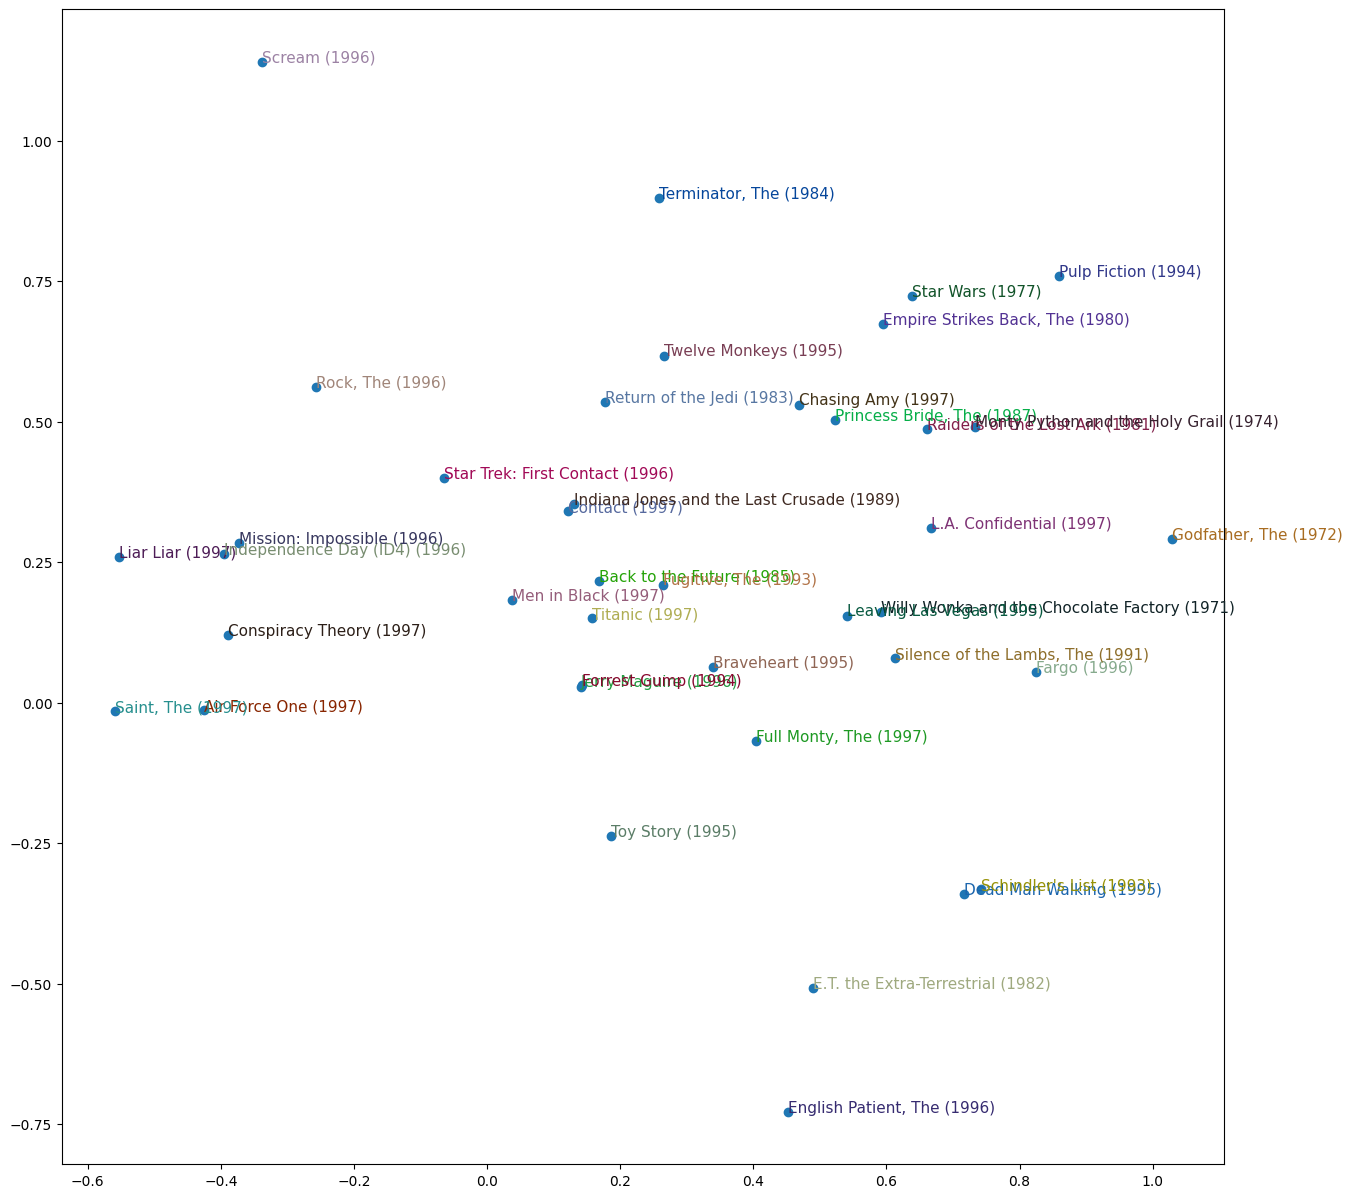

In [51]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(40))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()


In [52]:
# recommend similar movies

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Toy Story (1995)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:5]
dls.classes['title'][idx]

(#4) ['Sound of Music, The (1965)','Beauty and the Beast (1991)','Miracle on 34th Street (1994)','Lion King, The (1994)']

In [53]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Toy Story (1995)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=False)[1:5]
dls.classes['title'][idx]

(#4) ['House Party 3 (1994)','Mad Love (1995)',"Lover's Knot (1996)",'Thin Line Between Love and Hate, A (1996)']

In [58]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Scream (1996)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:10]
dls.classes['title'][idx]

(#9) ['Nightmare on Elm Street, A (1984)','Scream 2 (1997)','I Know What You Did Last Summer (1997)','Interview with the Vampire (1994)','Seven (Se7en) (1995)','Starship Troopers (1997)','Game, The (1997)','White Squall (1996)','Young Guns II (1990)']

In [59]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Scream (1996)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=False)[1:5]
dls.classes['title'][idx]

(#4) ['Disclosure (1994)','Swept from the Sea (1997)',"C'est arrivé près de chez vous (1992)",'Red Firecracker, Green Firecracker (1994)']